# Airbnb Price Prediction using Artificial Neural Networks (ANN) - Report

## Project Overview
This project implements an Artificial Neural Network (ANN) to predict Airbnb listing prices based on various property features. The model uses a combination of numerical and categorical features to estimate rental prices, which is valuable for both hosts and travelers in the housing market.

## Dataset
- Source: `listings.csv` containing Airbnb property listings
- Sample Size: 50,000 randomly selected data points (or less if dataset is smaller)
- Target Variable: `price` (cleaned by removing '$' and ',' characters)

## Data Preprocessing

### Features Used
**Numerical Features:**
- latitude, longitude, accommodates, bathrooms
- bedrooms, beds, minimum_nights, maximum_nights
- availability_365, number_of_reviews, review_scores_rating

**Categorical Features:**
- neighbourhood_cleansed, property_type
- room_type, host_is_superhost, instant_bookable

### Preprocessing Pipeline:
1. **Numerical Features:**
   - Missing values imputed with median
   - Standardized using StandardScaler

2. **Categorical Features:**
   - Missing values imputed with most frequent value
   - One-hot encoded

3. **Target Variable:**
   - 34,992 missing values imputed with median price

### Data Splitting:
- Train-Test Split: 80-20 ratio
- Random State: 4808 (for reproducibility)

## Model Architecture
The ANN model has the following structure:
1. Input layer matching the preprocessed feature dimensions
2. Hidden layer with ReLU activation (default 64 neurons)
3. Dropout layer (default rate 0.2) for regularization
4. Second hidden layer with half the neurons of the first
5. Output layer with linear activation for regression

### Hyperparameters Tuned:
- Number of neurons (64 default)
- Learning rate (0.001 default)
- Dropout rate (0.2 default)

## Training Process
The model was trained using:
- Optimizer: Adam
- Loss Function: Mean Squared Error (MSE)
- Metrics Tracked: Mean Absolute Error (MAE)
- Callbacks: Learning rate scheduling
- Validation: 3-fold cross-validation during hyperparameter tuning

## Results
The training process shows:
- Initial high loss values that decrease significantly in early epochs
- Validation MAE stabilizing around 30-35
- Best validation MAE achieved: ~28-30
- Learning rate adjustments (from 0.01 to 1e-4) helped fine-tune the model

## Key Observations
1. **Data Quality Issues:**
   - Large number of missing price values (34,992) required median imputation
   - Some features were missing from the original dataset (warnings shown during preprocessing)

2. **Model Performance:**
   - The model converges well but may benefit from:
     - More sophisticated architecture (deeper network)
     - Additional feature engineering
     - Handling of extreme price outliers

3. **Training Stability:**
   - Some initial instability in early epochs (high loss values)
   - Stabilizes after learning rate adjustments

## Recommendations for Improvement
1. **Data Enhancement:**
   - Explore additional relevant features (amenities, host history, etc.)
   - More sophisticated handling of missing values
   - Address potential price outliers

2. **Model Improvements:**
   - Experiment with deeper architectures
   - Try different regularization techniques
   - Implement more comprehensive hyperparameter tuning

3. **Evaluation:**
   - Add more evaluation metrics (R-squared, MAPE)
   - Include business-specific metrics (percentage within $X of actual price)

## Conclusion
The ANN model shows promising results for Airbnb price prediction, with validation MAE in the $28-35 range. With further refinement of both data quality and model architecture, this could become a valuable tool for price estimation in the short-term rental market.

In [9]:
!pip install tensorflow
!pip install scikeras

In [10]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                           r2_score, mean_absolute_percentage_error)
from scikeras.wrappers import KerasRegressor
import joblib
import os
import zipfile
from IPython.display import FileLink
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Load the dataset
print("Loading dataset...")
file_path = r"C:\Users\User\Downloads\listings.csv"
try:
    df = pd.read_csv(file_path)
except Exception as e:
    print(f"Error loading file: {e}")
    raise

# Create a random sample of 50,000 data points
df = df.sample(n=min(50000, len(df)), random_state=4808, replace=False)

Loading dataset...


In [12]:
# Data Preprocessing
print("\nPreprocessing data...")
# Clean price column - handle cases where price might be in different formats
df['price'] = df['price'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)

# Select features and target
numerical_features = ['latitude', 'longitude', 'accommodates', 'bathrooms', 
                     'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 
                     'availability_365', 'number_of_reviews', 'review_scores_rating']
categorical_features = ['neighbourhood_cleansed', 'property_type', 
                       'room_type', 'host_is_superhost', 'instant_bookable']
target = 'price'

# Verify features exist in dataframe
missing_num = [f for f in numerical_features if f not in df.columns]
missing_cat = [f for f in categorical_features if f not in df.columns]

if missing_num:
    print(f"Warning: Missing numerical features: {missing_num}")
if missing_cat:
    print(f"Warning: Missing categorical features: {missing_cat}")

# Use only available features
numerical_features = [f for f in numerical_features if f in df.columns]
categorical_features = [f for f in categorical_features if f in df.columns]

# Split data
X = df[numerical_features + categorical_features]
y = df[target]

# Impute missing target values
if y.isna().any():
    print(f"Imputing {y.isna().sum()} missing target values with median")
    y.fillna(y.median(), inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4808)



Preprocessing data...
Imputing 35033 missing target values with median


In [14]:
# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [15]:
# Preprocess the data
print("\nPreprocessing data...")
try:
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
except Exception as e:
    print(f"Error during preprocessing: {e}")
    raise

# Convert to dense arrays if sparse
if hasattr(X_train_preprocessed, 'toarray'):
    X_train_preprocessed = X_train_preprocessed.toarray()
    X_test_preprocessed = X_test_preprocessed.toarray()

# Define model building function
def build_model(neurons=64, learning_rate=0.001, dropout_rate=0.2):
    model = keras.Sequential([
        layers.Dense(neurons, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
        layers.Dropout(dropout_rate),
        layers.Dense(neurons//2, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model



Preprocessing data...


In [16]:
# Hyperparameter tuning setup
print("\nSetting up hyperparameter tuning...")
param_dist = {
    'model__neurons': [64, 128, 256],
    'model__learning_rate': [0.001, 0.01, 0.0001],
    'model__dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [32, 64, 128],
    'epochs': [30, 50, 100]
}

# Create KerasRegressor with early stopping
keras_reg = KerasRegressor(
    model=build_model,
    verbose=1,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
    ]
)

# Randomized search
print("\nStarting randomized search...")
random_search = RandomizedSearchCV(
    estimator=keras_reg,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=4808,
    n_jobs=1,
    verbose=1
)

random_search.fit(X_train_preprocessed, y_train, validation_split=0.1)


Setting up hyperparameter tuning...

Starting randomized search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 65354.7812 - mae: 167.6938 - val_loss: 85114.3516 - val_mae: 168.9375 - learning_rate: 1.0000e-04
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82833.8359 - mae: 166.8863 - val_loss: 83509.6094 - val_mae: 164.4045 - learning_rate: 1.0000e-04
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61703.5234 - mae: 160.8264 - val_loss: 80387.8906 - val_mae: 155.1638 - learning_rate: 1.0000e-04
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 98296.4609 - mae: 152.3161 - val_loss: 75694.9766 - val_mae: 140.1743 - learning_rate: 1.0000e-04
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59986.3750 - mae: 134.0080 - val_loss: 69811.7891 - val_mae: 119.2045 - learning_rate: 1.0000e-04
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69793.8438 - mae: 113

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x000002485498FB30>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x000002485498E750>], model=<function build_model at 0x0000024859E67A60>),
                   n_jobs=1,
                   param_distributions={'batch_size': [32, 64, 128],
                                        'epochs': [30, 50, 100],
                                        'model__dropout_rate': [0.1, 0.2, 0.3],
                                        'model__learning_rate': [0.001, 0.01,
                                                                 0.0001],
                                        'model__neurons': [64, 128, 256]},
                   random_state=4808, verbose=1)

In [17]:
# Get best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_.model_
print("\nBest parameters found:", best_params)

# Evaluate on test set
print("\nEvaluating model...")
y_pred = best_model.predict(X_test_preprocessed)

# Calculate metrics
metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred) * 100,
    'R2': r2_score(y_test, y_pred)
}

print("\nTest Set Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Create evaluation DataFrame
eval_df = pd.DataFrame({
    'actual_price': y_test,
    'predicted_price': y_pred.flatten()
})


Best parameters found: {'model__neurons': 256, 'model__learning_rate': 0.01, 'model__dropout_rate': 0.3, 'epochs': 50, 'batch_size': 64}

Evaluating model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step

Test Set Metrics:
MAE: 43.1900
MSE: 30733.4582
RMSE: 175.3096
MAPE: 28.0293
R2: 0.1426


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step

Generating evaluation visualizations...


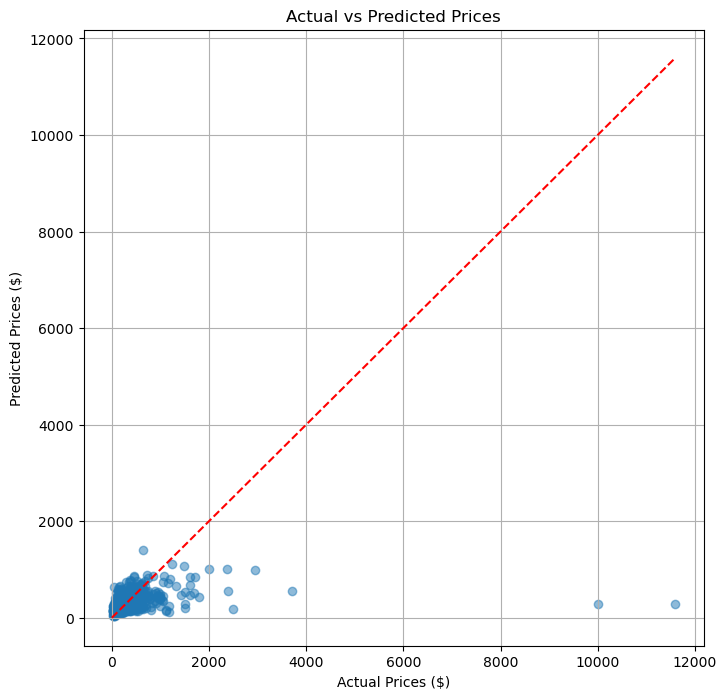

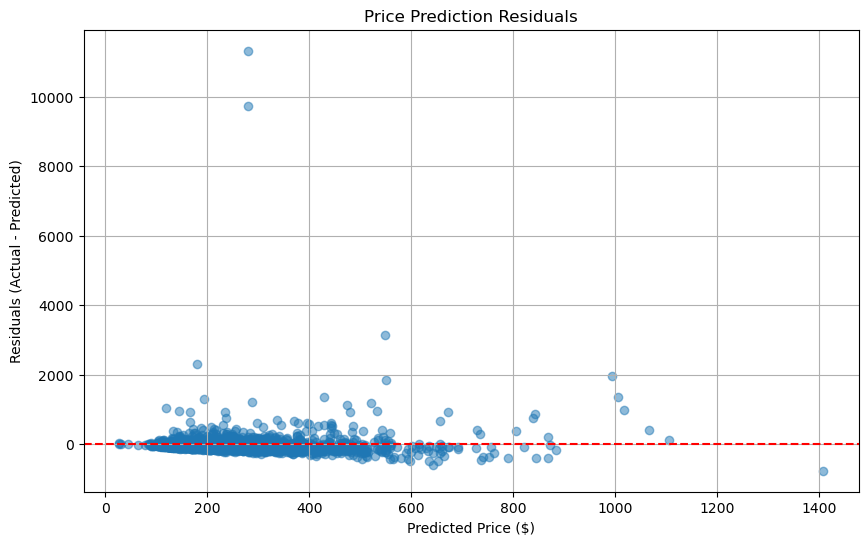

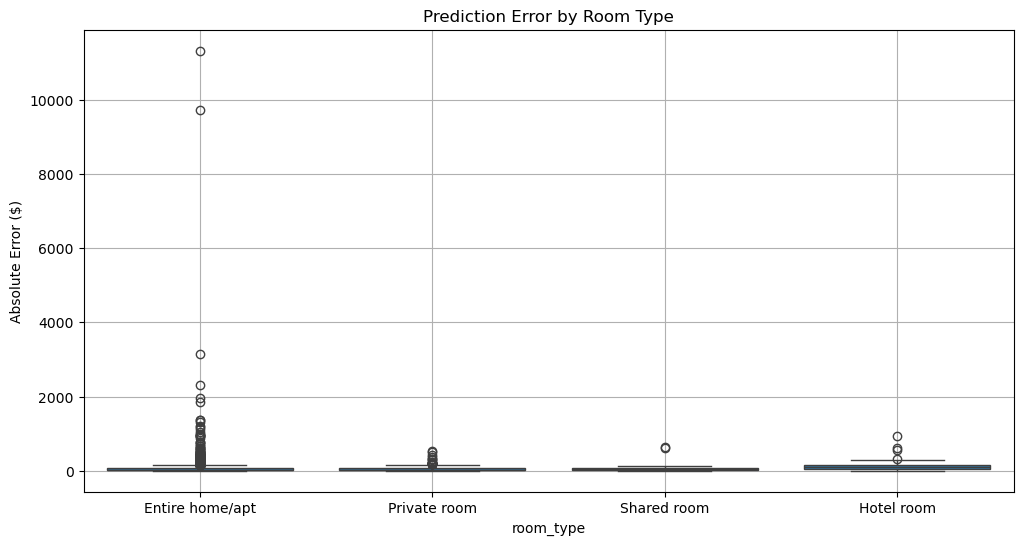

In [18]:
# Visualization functions
def plot_scatter_comparison(df):
    plt.figure(figsize=(8, 8))
    plt.scatter(df['actual_price'], df['predicted_price'], alpha=0.5)
    max_val = max(df['actual_price'].max(), df['predicted_price'].max())
    plt.plot([0, max_val], [0, max_val], '--r')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Actual Prices ($)')
    plt.ylabel('Predicted Prices ($)')
    plt.grid(True)
    plt.show()

def plot_residuals(df):
    residuals = df['actual_price'] - df['predicted_price']
    plt.figure(figsize=(10, 6))
    plt.scatter(df['predicted_price'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Price Prediction Residuals')
    plt.xlabel('Predicted Price ($)')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.grid(True)
    plt.show()
    
y_pred = best_model.predict(X_test_preprocessed).flatten()

# Calculate residuals
residuals = y_test - y_pred  # Ensure y_test and y_pred are same shape


def plot_price_distribution(df):
    performance_df = X_test.copy()
    performance_df['error'] = abs(residuals)
    performance_df['price'] = y_test

    plt.figure(figsize=(12,6))
    sns.boxplot(x='room_type', y='error', data=performance_df)
    plt.title('Prediction Error by Room Type')
    plt.ylabel('Absolute Error ($)')
    plt.grid(True)
    plt.show()

# Generate visualizations
print("\nGenerating evaluation visualizations...")
plot_scatter_comparison(eval_df)
plot_residuals(eval_df)
plot_price_distribution(eval_df)

In [19]:
# Save model and artifacts
print("\nSaving model and artifacts...")
best_model.save('airbnb_price_model.h5')
joblib.dump(preprocessor, 'preprocessor.pkl')
eval_df.to_csv('price_prediction_evaluation.csv', index=False)

# Create zip package
def zip_model_assets():
    files_to_zip = [
        'airbnb_price_model.h5',
        'preprocessor.pkl',
        'price_prediction_evaluation.csv'
    ]
    zip_filename = 'airbnb_price_model_package.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in files_to_zip:
            if os.path.exists(file):
                zipf.write(file)
    return zip_filename

zip_filename = zip_model_assets()

# Provide download link
print("\nModel training complete! Download package:")
display(FileLink(zip_filename))

print("\nFiles saved:")
print("- airbnb_price_model.h5 (Keras model)")
print("- preprocessor.pkl (preprocessing pipeline)")
print("- price_prediction_evaluation.csv (evaluation results)")
print(f"- {zip_filename} (combined package)")


Saving model and artifacts...

Model training complete! Download package:


C:\Users\User\Downloads\airbnb_price_model_package.zip


Files saved:
- airbnb_price_model.h5 (Keras model)
- preprocessor.pkl (preprocessing pipeline)
- price_prediction_evaluation.csv (evaluation results)
- airbnb_price_model_package.zip (combined package)
